In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """単純なConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [2]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

In [3]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]


In [9]:
t_train[56784]

4

In [5]:
max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

train loss:2.300299524550509
=== epoch:1, train acc:0.19, test acc:0.195 ===
train loss:2.297680216639115
train loss:2.291643854493337
train loss:2.2860320349977026
train loss:2.2771480947329583
train loss:2.2738396339277256
train loss:2.245891545698033
train loss:2.228062170428405
train loss:2.1875665747598934
train loss:2.179680426113259
train loss:2.1367235213567928
train loss:2.1044531187026525
train loss:2.0540974971572954
train loss:2.054807966056612
train loss:1.9582734954817707
train loss:1.9272655939689225
train loss:1.864571125538392
train loss:1.787867756133346
train loss:1.7587377388297727
train loss:1.6271867698108187
train loss:1.557560549899423
train loss:1.4545313462533307
train loss:1.2749409803083955
train loss:1.3947848553315523
train loss:1.212571290247653
train loss:1.2227118583949883
train loss:1.004968638184303
train loss:1.0108849825733215
train loss:0.9404746147937556
train loss:0.8508859842544163
train loss:1.0565691552021796
train loss:0.7600793681949238
trai

train loss:0.4294381951806171
train loss:0.23992537533675076
train loss:0.3089509941558824
train loss:0.5429310292711093
train loss:0.1884843306096458
train loss:0.23183797470760406
train loss:0.3590306821108858
train loss:0.12156249569216586
train loss:0.22718723834653257
train loss:0.2334779513695152
train loss:0.22242385549615418
train loss:0.2986555517930629
train loss:0.23594551379562492
train loss:0.3182448109232725
train loss:0.21141799214450022
train loss:0.2033432285120851
train loss:0.27115399282069474
train loss:0.3259173373469717
train loss:0.24368528529558323
train loss:0.25765284808436817
train loss:0.1517335776612448
train loss:0.3360673462602375
train loss:0.25563906469576003
train loss:0.23510066510845512
train loss:0.253684265486391
train loss:0.4151617364334048
train loss:0.1923468618590426
train loss:0.26196793630141973
train loss:0.2153142822744644
train loss:0.16009766312339965
train loss:0.3486192500666799
train loss:0.2759933705350165
train loss:0.22858320129669

train loss:0.051596489151849126
train loss:0.12565545982645837
train loss:0.10633285405226274
train loss:0.15188933369783897
train loss:0.1268425465795943
train loss:0.12582560693615175
train loss:0.17327626191689455
train loss:0.11898213416690356
train loss:0.1285529338159019
train loss:0.1324528723531959
train loss:0.11092160354285101
train loss:0.10112228125991778
train loss:0.057007824925409414
train loss:0.0888257268514321
train loss:0.18849345264246867
train loss:0.2577473371472885
train loss:0.16452154068090596
train loss:0.2653803509168385
train loss:0.06903699177123078
train loss:0.21487072550562597
train loss:0.1196887386815827
train loss:0.07970381392250721
train loss:0.11233330668952175
train loss:0.2040323429395141
train loss:0.1559075095198119
train loss:0.14442842425356792
train loss:0.11425951044903426
train loss:0.07832586829645345
train loss:0.2576930770410986
train loss:0.10728478867956877
train loss:0.16345471523180005
train loss:0.13319576083237608
train loss:0.075

train loss:0.1373760862679803
train loss:0.05821755894308909
train loss:0.14514608035166593
train loss:0.18791093211994309
train loss:0.13764367970257793
train loss:0.14411077653075854
train loss:0.09903859391706135
train loss:0.055290963673136274
train loss:0.0829558731696117
train loss:0.09762817230257603
train loss:0.05146399297222275
train loss:0.06679482575096167
train loss:0.10141466604184422
train loss:0.08625160278539981
train loss:0.06510206020441331
train loss:0.198510610516912
train loss:0.10000019480745889
train loss:0.03028375765490489
train loss:0.1840122020584456
train loss:0.12680437010979062
train loss:0.07780889261081647
train loss:0.12451357456398326
train loss:0.08063666791274715
train loss:0.11617855672192434
train loss:0.09731231210876837
train loss:0.08246514627136353
train loss:0.18300990195362166
train loss:0.08905255389066564
train loss:0.08591550065685843
train loss:0.07245127082497932
train loss:0.18871875927803716
train loss:0.047153041748172767
train loss:

train loss:0.1560561286669002
train loss:0.058822199361654955
train loss:0.15663218504971518
train loss:0.08093293181710397
train loss:0.054142031088438285
train loss:0.049682019505937446
train loss:0.11060196837565126
train loss:0.05288924414650758
train loss:0.06913609077439947
train loss:0.020250668780647248
train loss:0.06754718974097666
train loss:0.0436683862995592
train loss:0.10837539259878462
train loss:0.15610613378651567
train loss:0.12793525271253908
train loss:0.0933335974317134
train loss:0.11856358868233595
train loss:0.14435646488164808
train loss:0.032150730693158346
train loss:0.07355636949166368
train loss:0.041638874406933014
train loss:0.05961684227176181
train loss:0.039694385177871105
train loss:0.05738767516654266
train loss:0.09180920218006504
train loss:0.09027513039934563
train loss:0.06687715944492656
train loss:0.1457554364058475
train loss:0.05460427276740686
train loss:0.04274609489238329
train loss:0.03919516556259995
train loss:0.040019044467323066
trai

train loss:0.06933585449888552
train loss:0.036906044288130005
train loss:0.03882643887391976
train loss:0.07189453104091421
train loss:0.030645190345170818
train loss:0.043266197811590086
train loss:0.11269938061226795
train loss:0.036627724514439824
train loss:0.06135277824538465
train loss:0.0686236753960832
train loss:0.04142450434781259
train loss:0.03632278879695725
train loss:0.058018562775916716
train loss:0.03476849027419694
train loss:0.10420186785129328
train loss:0.06437189593727528
train loss:0.09809682298589133
train loss:0.02643731296443146
train loss:0.035800361247241744
train loss:0.016733905489161052
train loss:0.0627520395624334
train loss:0.05733525242870564
train loss:0.0752160036897484
train loss:0.05903681391719395
train loss:0.06273050972030286
train loss:0.03526480615781471
train loss:0.02657244906095246
train loss:0.10747485756668938
train loss:0.015347910122354669
train loss:0.14312721062223807
train loss:0.016010313923542
train loss:0.022427559968112763
trai

train loss:0.03056153976537032
train loss:0.03382281587380264
train loss:0.07013382846878939
train loss:0.0592781750312193
train loss:0.06155689164927984
train loss:0.09112937408948957
train loss:0.08420554868478945
train loss:0.05528296392659917
train loss:0.03166077824738793
train loss:0.05656621246396568
train loss:0.03313372453295094
train loss:0.09504700181196753
train loss:0.10730821997084193
train loss:0.0414692281564444
train loss:0.044472149622806795
train loss:0.01988183656588601
train loss:0.06121335126165072
train loss:0.033733144560716084
train loss:0.05743986702741008
train loss:0.09172029962191398
train loss:0.0857552932663538
train loss:0.05956993548295391
train loss:0.00991076714770614
train loss:0.06372030807484953
train loss:0.07317580029376936
train loss:0.04062822463164772
train loss:0.0657418178564296
train loss:0.1114284842344542
train loss:0.0331900893748958
train loss:0.019558366069979675
train loss:0.09660946182501264
train loss:0.07119989582116049
train loss:

train loss:0.03704983746537728
train loss:0.015881446492277716
train loss:0.10104641889426819
train loss:0.10147488809852309
train loss:0.044686932600677604
train loss:0.04038652974649492
train loss:0.036752401913117634
train loss:0.06041672745648726
train loss:0.06126053600063999
train loss:0.06911765753816583
train loss:0.02943101801818292
train loss:0.07370672294977915
train loss:0.0524797247588014
train loss:0.07862394585609352
train loss:0.04048371686265237
train loss:0.03890185329264646
train loss:0.028546729225398942
train loss:0.03588969890698746
train loss:0.028179955783214528
train loss:0.02139927494743982
train loss:0.025914463123640902
train loss:0.128889381086556
train loss:0.020885378206510784
train loss:0.04841419099180669
train loss:0.02663167231758683
train loss:0.07795466113009718
train loss:0.06517317414906225
train loss:0.10428974789468871
train loss:0.026441480282818244
train loss:0.05834389206740826
train loss:0.01451779654958486
train loss:0.07167716432426463
tra

train loss:0.01667001482480958
train loss:0.012923708063291718
train loss:0.07889161832487859
train loss:0.0055666780410025644
train loss:0.05648218302843772
train loss:0.04100887405354404
train loss:0.04860941172282383
train loss:0.026642703993217075
train loss:0.0494494348110213
train loss:0.060586440449173606
train loss:0.10042019143060257
train loss:0.043953410968990345
train loss:0.048974948049402424
train loss:0.05392419065688163
train loss:0.022298856479047
train loss:0.04665557844635925
train loss:0.02482619916587731
train loss:0.005248983978057325
train loss:0.011107232380140733
train loss:0.013360091695568843
train loss:0.06186480815149244
train loss:0.05714761382551008
train loss:0.03010622539444913
train loss:0.012934291808475934
train loss:0.01706775149609649
train loss:0.06004618194077489
train loss:0.039384953966332174
train loss:0.03796218925782546
train loss:0.13792829397160897
train loss:0.08672555999861103
train loss:0.05558324151197356
train loss:0.03924614464485058

train loss:0.02981450385097181
train loss:0.06862863392574108
train loss:0.0551722577975833
train loss:0.022514796992032616
train loss:0.0767234577431546
train loss:0.036818138305424575
train loss:0.018843948098564968
train loss:0.04612890581492013
train loss:0.06299077595982167
train loss:0.021134390715794513
train loss:0.02295018322152972
train loss:0.013027208750587257
train loss:0.06883579668335131
train loss:0.04089258105600958
train loss:0.06168151986047406
train loss:0.016672673130070512
train loss:0.005228090661051308
train loss:0.017416093899910053
train loss:0.041914957014710735
train loss:0.014113120350845196
=== epoch:5, train acc:0.985, test acc:0.983 ===
train loss:0.06784226210419289
train loss:0.024008074431284287
train loss:0.025807153830970205
train loss:0.013567820297298834
train loss:0.04786009321861294
train loss:0.033892589840618915
train loss:0.04770126379657851
train loss:0.1603536490765755
train loss:0.05538729088257159
train loss:0.09387086972332276
train loss

train loss:0.04657084731496929
train loss:0.04497720677111843
train loss:0.024823381525343195
train loss:0.006056021425898605
train loss:0.03277655628569798
train loss:0.029092253008087265
train loss:0.023472695946372944
train loss:0.053351580179868234
train loss:0.030061400387619144
train loss:0.0755580341093881
train loss:0.007181165888179175
train loss:0.009771839449457018
train loss:0.010457499740293509
train loss:0.010340378302131564
train loss:0.006592820796364984
train loss:0.021088063581803672
train loss:0.04648298372629703
train loss:0.01448412956791678
train loss:0.07344940981421205
train loss:0.010019763659254763
train loss:0.013674899567666172
train loss:0.0561631093480876
train loss:0.08452851824166657
train loss:0.05361455459426098
train loss:0.01915407630895332
train loss:0.016227060843157663
train loss:0.03305926735156295
train loss:0.01506119469817824
train loss:0.015430408285592324
train loss:0.06107560175113788
train loss:0.018892351793867706
train loss:0.01845136642

train loss:0.03328132718614963
train loss:0.016270654760986963
train loss:0.011226367894324987
train loss:0.027760945590231994
train loss:0.023926269627412643
train loss:0.01764235840627907
train loss:0.06192009262878598
train loss:0.02567997148834724
train loss:0.006630248708592213
train loss:0.08182962080882852
train loss:0.0542977674643843
train loss:0.0591673402905609
train loss:0.04799876987521833
train loss:0.0015640865989425665
train loss:0.07008895242340997
train loss:0.02745061437532202
train loss:0.009986616503855416
train loss:0.04358877467910213
train loss:0.06767705851838907
train loss:0.013774039781893267
train loss:0.023031724815344153
train loss:0.06585586831630402
train loss:0.04376309985545618
train loss:0.047414069397990914
train loss:0.025072436006989544
train loss:0.006286714847980154
train loss:0.03641177357513489
train loss:0.01767143416730762
train loss:0.1094203683448667
train loss:0.02090542693570887
train loss:0.012204148674198265
train loss:0.010944551453122

train loss:0.0054817963058325335
train loss:0.005716244477046429
train loss:0.009073727174536014
train loss:0.011005312858004077
train loss:0.01896896014890131
train loss:0.012206771343949962
train loss:0.008261445694623504
train loss:0.010532006815948191
train loss:0.014878465484942451
train loss:0.03273192734410978
train loss:0.005050207995522287
train loss:0.017542338048513146
train loss:0.015394502619184007
train loss:0.00864802826258218
train loss:0.004300955331650288
train loss:0.008446294862560443
train loss:0.013741172806522109
train loss:0.03891527955111501
train loss:0.06488165307261766
train loss:0.008601908403078892
train loss:0.02412972724116223
train loss:0.015538566596716905
train loss:0.023579281595418777
train loss:0.022018033157460794
train loss:0.01857060252199583
train loss:0.049605330307786286
train loss:0.01209082818333108
train loss:0.009514143024794518
train loss:0.0250553249129838
train loss:0.020863992314842313
train loss:0.004344649727038948
train loss:0.0220

train loss:0.02335676540668251
train loss:0.03438202987949466
train loss:0.005525942803300854
train loss:0.007074883461004019
train loss:0.02275726147363502
train loss:0.00433103443718518
train loss:0.01174009761178891
train loss:0.006843815712520349
train loss:0.008559035337135966
train loss:0.01189018751228888
train loss:0.021113135521961555
train loss:0.03932391209847861
train loss:0.015552765949431254
train loss:0.05243233458478798
train loss:0.014241604294240304
train loss:0.04186207430223365
train loss:0.007509343024064926
train loss:0.017667269986244155
train loss:0.021502480761803007
train loss:0.013602472543864002
train loss:0.017095005753041872
train loss:0.01767591741738882
train loss:0.02617408447086663
train loss:0.011478656901813966
train loss:0.014138551308105176
train loss:0.009181474336317098
train loss:0.004691636794820967
train loss:0.019760077837562527
train loss:0.03231274364552706
train loss:0.013844016233393494
train loss:0.006897322087441614
train loss:0.0163240

train loss:0.008021684256870585
train loss:0.018801988647948385
train loss:0.011487250261519078
train loss:0.025389856031890173
train loss:0.02443536918325976
train loss:0.05451872864752999
train loss:0.015687730434426953
train loss:0.013242757131431715
train loss:0.03381565875341023
train loss:0.013419395661215456
train loss:0.010623001958371037
train loss:0.06109353633965266
train loss:0.01892081840680637
train loss:0.025373724084442426
train loss:0.018079495762367732
train loss:0.013373147159542083
train loss:0.0288380311967861
train loss:0.007456118342370821
train loss:0.0033118108736537146
train loss:0.031170054633430005
train loss:0.023251983778238356
train loss:0.008474217364665429
train loss:0.026719507984097515
train loss:0.015442556183254765
train loss:0.005624091697309624
train loss:0.06033448172907524
train loss:0.009593943033104157
train loss:0.09417946064656625
train loss:0.02553276933254278
train loss:0.01835451902938246
train loss:0.009926263058364642
train loss:0.07074

train loss:0.057272966975327126
train loss:0.03581541427319291
train loss:0.008347482280245592
train loss:0.006807894710001512
train loss:0.005127214741262682
train loss:0.042556016721370084
train loss:0.05586375960657426
train loss:0.004326124330291563
train loss:0.001858054651331692
train loss:0.023799248707347193
train loss:0.05452438107881244
train loss:0.014338066207204136
train loss:0.004248809686425545
train loss:0.012932658855085565
train loss:0.03429194638125975
train loss:0.008579547376962182
train loss:0.020946677162160334
train loss:0.006475048014460467
train loss:0.10136658046813989
train loss:0.050073994120597376
train loss:0.037171617559425045
train loss:0.007198523281196878
train loss:0.0014842752710338093
train loss:0.022804461994739608
train loss:0.0039615693160808515
train loss:0.014712042821136887
train loss:0.011739813124006383
train loss:0.04015326453250998
train loss:0.014458077281003073
train loss:0.01008534231509444
train loss:0.036392471570957444
train loss:0.

train loss:0.07607922229136851
train loss:0.004685262933475037
train loss:0.007276766472808547
train loss:0.0196165774907485
train loss:0.009159504602227442
train loss:0.0023639825417438908
train loss:0.0030105002900074566
=== epoch:8, train acc:0.991, test acc:0.984 ===
train loss:0.006900544518159607
train loss:0.03462681243944979
train loss:0.007476887459776939
train loss:0.056294663005269585
train loss:0.011498245783062055
train loss:0.016921701816580818
train loss:0.002478698559974257
train loss:0.025339202008938102
train loss:0.00877905329539797
train loss:0.0031606960690816334
train loss:0.007815227227081644
train loss:0.00732518221337093
train loss:0.0022981531061898146
train loss:0.003029400491984841
train loss:0.07353316086279019
train loss:0.006280862845038534
train loss:0.012268575882596668
train loss:0.016544334604307563
train loss:0.0012932821090173884
train loss:0.03341976343825248
train loss:0.029585522222673886
train loss:0.018573609870510727
train loss:0.0398940386327

train loss:0.0016426394926594553
train loss:0.05903750007179602
train loss:0.061287847214484624
train loss:0.06945387473240676
train loss:0.006309505755559217
train loss:0.014088876071558334
train loss:0.027182929669089275
train loss:0.015002545284367653
train loss:0.01770687785943831
train loss:0.0028823507542682395
train loss:0.004000467084323369
train loss:0.017437606898600102
train loss:0.007387473769123046
train loss:0.01304959954475929
train loss:0.0044581236634874165
train loss:0.01848069308573219
train loss:0.008507898991116428
train loss:0.009630199973876406
train loss:0.017567677213784095
train loss:0.0024764240114251313
train loss:0.16178650415507664
train loss:0.006857082600151916
train loss:0.006992426335207363
train loss:0.006095203472095821
train loss:0.007972698653213584
train loss:0.009938327741506938
train loss:0.0069872275807000015
train loss:0.01520331939477782
train loss:0.0020718221361654006
train loss:0.013008679761701924
train loss:0.007923310578981317
train los

train loss:0.008860941441485018
train loss:0.012988686703160836
train loss:0.008028924240058476
train loss:0.014121313021204184
train loss:0.03319027210051941
train loss:0.056876200269413146
train loss:0.033096965745982046
train loss:0.08934842752189454
train loss:0.014298234666177616
train loss:0.010429177116921963
train loss:0.023366528219805498
train loss:0.018558500382737545
train loss:0.003113200060482437
train loss:0.011941397680698164
train loss:0.003115042693423571
train loss:0.009921248073622524
train loss:0.004719120606144124
train loss:0.01601905654042802
train loss:0.012756225451687107
train loss:0.004394279764903656
train loss:0.020833578041736012
train loss:0.010853318453279248
train loss:0.007450032628452111
train loss:0.001753889175610623
train loss:0.007078243560248826
train loss:0.005276460567740647
train loss:0.0012453340064505019
train loss:0.016278164513963488
train loss:0.04677306495448753
train loss:0.017532709790040416
train loss:0.01840366600664177
train loss:0

train loss:0.0013161903366368832
train loss:0.0045016468233490875
train loss:0.009898981217038576
train loss:0.0011143296689715438
train loss:0.003963408642312287
train loss:0.06445250608451208
train loss:0.005750832694190509
train loss:0.01134687970887803
train loss:0.012272533482220349
train loss:0.006260671440742467
train loss:0.0014251102048120127
train loss:0.005053631193937182
train loss:0.008582343411140461
train loss:0.0059326859344431245
train loss:0.003018047830543192
train loss:0.0028873758377022797
train loss:0.007681691937960081
train loss:0.0014261732754029608
train loss:0.014860337125009932
train loss:0.027706946514818934
train loss:0.004351226775248112
train loss:0.06001369703154207
train loss:0.008518534584234336
train loss:0.0037496083490693084
train loss:0.03249839292130885
train loss:0.01648281781167872
train loss:0.016256944879505505
train loss:0.020264497123315604
train loss:0.01863310355825298
train loss:0.004069714045871891
train loss:0.010625230137025533
train 

train loss:0.00404838970265188
train loss:0.002518414444365957
train loss:0.015130455168435092
train loss:0.028899064594595
train loss:0.009233236586329168
train loss:0.01969238838477845
train loss:0.014103327182630661
train loss:0.009428750167843097
train loss:0.033538942949861296
train loss:0.010454228027663983
train loss:0.013132216820849963
train loss:0.0169844741831821
train loss:0.00438953602985788
train loss:0.004543034447593813
train loss:0.007057585430199711
train loss:0.012066590608516534
train loss:0.034972888214558184
train loss:0.01463848389276397
train loss:0.004543193822827365
train loss:0.002967049171000737
train loss:0.03262323012238601
train loss:0.05038704513071961
train loss:0.024887208291919576
train loss:0.0027461802979484324
train loss:0.008155457330941841
train loss:0.04073794650147623
train loss:0.004440554689249582
train loss:0.003574870532090847
train loss:0.002085240179659791
train loss:0.037937564441910404
train loss:0.03311767479450937
train loss:0.0035989

train loss:0.039567310207249684
train loss:0.00503425534973461
train loss:0.01080246584546343
train loss:0.030333360302795098
train loss:0.002973401408512189
train loss:0.002724359711308078
train loss:0.01156300373426903
train loss:0.00978240019117095
train loss:0.0013029630631063041
train loss:0.009496649616266872
train loss:0.005121049132804914
train loss:0.005946431528866586
train loss:0.0182855080389979
train loss:0.01136858466279796
train loss:0.004846567544444007
train loss:0.06160246956198287
train loss:0.00944270148827575
train loss:0.010400278438853707
train loss:0.0039191853479132975
train loss:0.012085978355009474
train loss:0.012696401931364489
train loss:0.010494615301670097
train loss:0.0033001216667513968
train loss:0.006291593398558949
train loss:0.009183294833733655
train loss:0.022448938747528117
train loss:0.005101566813285234
train loss:0.00236755407131653
train loss:0.0034622552440589454
train loss:0.004066335487886589
train loss:0.009891081329071443
train loss:0.0

train loss:0.0012554031207056523
train loss:0.0023541606802325514
train loss:0.0022580668574642433
train loss:0.005635601020844837
train loss:0.006791525472440304
train loss:0.003603474295059198
train loss:0.0005569833544953358
train loss:0.002912262953462766
train loss:0.005817925828236734
train loss:0.005415824543249502
train loss:0.0011821830550929626
train loss:0.017333719701230793
train loss:0.0010237121987669697
train loss:0.009012663488639584
train loss:0.019671163533970193
train loss:0.011466066943948234
train loss:0.008868306376567697
train loss:0.008253358576393333
train loss:0.0048830438624487705
train loss:0.0026974034546744137
train loss:0.029745223927067747
train loss:0.007081517661708171
train loss:0.00043855715814038925
train loss:0.0011204219225156935
train loss:0.0027166982312319134
train loss:0.0048248867724341735
train loss:0.0030736878769336857
train loss:0.02187308346825984
train loss:0.010760001221985283
train loss:0.005640953508875023
train loss:0.01912230093742

train loss:0.0037351841875684876
train loss:0.012844805913914199
train loss:0.002028504702928388
train loss:0.057297965824017145
train loss:0.058564529886660936
train loss:0.003195293133768161
train loss:0.023891281557867242
train loss:0.0009983138608657808
train loss:0.008700775716027497
train loss:0.016264556238636065
train loss:0.05922267044907896
train loss:0.01668583565951058
train loss:0.0008960866441561936
=== epoch:11, train acc:0.997, test acc:0.986 ===
train loss:0.006471008943951573
train loss:0.003467855263850752
train loss:0.00487168489220444
train loss:0.032057438641449304
train loss:0.007708753094906802
train loss:0.034419826041215386
train loss:0.016035525038044115
train loss:0.004614582072989505
train loss:0.012998715396941075
train loss:0.0017783306526000379
train loss:0.04741979357331176
train loss:0.011971613310571004
train loss:0.004592722504279436
train loss:0.0020731329282112536
train loss:0.008996046435752686
train loss:0.010416554819440831
train loss:0.00096887

train loss:0.005901811526769314
train loss:0.015629095242491932
train loss:0.004259804107354996
train loss:0.017173963041593868
train loss:0.008384967121336873
train loss:0.0014638335110130393
train loss:0.009061583122534928
train loss:0.0005519553133287088
train loss:0.0008531675907460567
train loss:0.003673924510220783
train loss:0.010723154850149685
train loss:0.005467262307767384
train loss:0.003565733132166856
train loss:0.0034620315600826985
train loss:0.011579462068701746
train loss:0.06043582807865393
train loss:0.0115736430281295
train loss:0.042666641598817605
train loss:0.03181489921447131
train loss:0.0017584642547913655
train loss:0.0017272761507308365
train loss:0.00028727533587131045
train loss:0.005832865698480718
train loss:0.004370414791925172
train loss:0.018523381063369333
train loss:0.0047594434068193225
train loss:0.011616913334346633
train loss:0.009459152073153091
train loss:0.0010089239474981929
train loss:0.006425646937913551
train loss:0.0032783316696743396
t

train loss:0.003092490696705914
train loss:0.0012009571438175038
train loss:0.0037677529673350962
train loss:0.00028150517868737006
train loss:0.010737837877893982
train loss:0.0044779571325998776
train loss:0.0004491503250629762
train loss:0.0008410365596295575
train loss:0.02025428104701297
train loss:0.007374750615789865
train loss:0.0012765225002951558
train loss:0.016084563562078935
train loss:0.0020233900863225584
train loss:0.0014617159266960924
train loss:0.0028068474987495194
train loss:0.03159751671305336
train loss:0.011949018216425005
train loss:0.0027282213717769728
train loss:0.008483159395701257
train loss:0.0009948867941287135
train loss:0.015464881357946549
train loss:0.0018825616504134623
train loss:0.0008568064664669043
train loss:0.0014904285291785465
train loss:0.018883700809715763
train loss:0.006327339815420354
train loss:0.0016627418428329873
train loss:0.0006456490187952813
train loss:0.0006111413380156747
train loss:0.00501332535543
train loss:0.00656021416519

train loss:0.002251863736434148
train loss:0.014085653336729368
train loss:0.0018912361871260624
train loss:0.0034773239164565596
train loss:0.021474975170590778
train loss:0.003257532571381779
train loss:0.019109641509504196
train loss:0.005992241486818634
train loss:0.004304864107465174
train loss:0.0007117470197947917
train loss:0.0010013794265859171
train loss:0.0004632333349356003
train loss:0.004428088081962101
train loss:0.005681864609836602
train loss:0.015481403621964712
train loss:0.010529016711176597
train loss:0.0008688086430180734
train loss:0.00451365122509053
train loss:0.0020077268455876702
train loss:0.0015480156199761603
train loss:0.0024738662539238528
train loss:0.0026844072481953924
train loss:0.011016121212024867
train loss:0.001668773967541032
train loss:0.0014062953657122304
train loss:0.002023057951293462
train loss:0.0036105591145253295
train loss:0.01971992218564274
train loss:0.001175576603293569
train loss:0.0025816485786945096
train loss:0.0022963337251554

train loss:0.00518749800136533
train loss:0.0028647317792492195
train loss:0.012296319031416836
train loss:0.004875328352626318
train loss:0.0005592556156641047
train loss:0.0015627380343739008
train loss:0.0015429027516866882
train loss:0.006604109738422379
train loss:0.002394628554548457
train loss:0.00033548316284113286
train loss:0.00044851771597177595
train loss:0.0877739642235727
train loss:0.0005223012897940202
train loss:0.006225567202041854
train loss:0.002145878136762296
train loss:0.0074401287933471135
train loss:0.0034496372667877635
train loss:0.001532729353281892
train loss:0.005280329303005037
train loss:0.0023905426482171235
train loss:0.005568212198690557
train loss:0.0020270158646145007
train loss:0.0006669032265539001
train loss:0.0015348231182473623
train loss:0.0031887426449120513
train loss:0.009833077852974654
train loss:0.0015808633543918928
train loss:0.0036667681747204976
train loss:0.00599568508982865
train loss:0.000762527156905197
train loss:0.0029050243582

train loss:0.0015790309165645913
train loss:0.0012333066825492935
train loss:0.005598751999232931
train loss:0.0010013927618172302
train loss:0.010282491975459059
train loss:0.002644050649509251
train loss:0.008796785147439475
train loss:0.0008787585384901113
train loss:0.0005845514273052003
train loss:0.0007228163298345033
train loss:0.0006605744599623882
train loss:0.0016978025378778985
train loss:0.0021746636747161817
train loss:0.008892038234764178
train loss:0.00023631224139675293
train loss:0.00021493462302821958
train loss:0.00076116934571185
train loss:0.0038287203786552763
train loss:0.002758203928662672
train loss:0.003144268675449843
train loss:0.0050548101468705295
train loss:0.00027912084586949706
train loss:0.0018184151348219848
train loss:0.0014540616241263324
train loss:0.001349474302198436
train loss:0.003876309937865758
train loss:0.0007171092409391807
train loss:0.0031759273576279414
train loss:0.0042931000419440726
train loss:0.00038163669141034334
train loss:0.0012

train loss:0.011281432364704937
train loss:0.0011202193002055908
train loss:0.0019010498130029537
train loss:0.008428465219169052
train loss:0.000895114234075729
train loss:0.004389221759947061
train loss:0.0004569853036510592
train loss:0.0029321001184694274
train loss:0.03794953506068108
train loss:0.0019136964951314017
train loss:0.0010866081198929061
train loss:0.002079431468832522
train loss:0.00017481444918316223
train loss:0.002245263400729052
train loss:0.007188298394287849
train loss:0.002623303493836336
train loss:0.0019499347050923994
train loss:0.002482398843273256
train loss:0.008329591174452504
train loss:0.005843749953625002
train loss:0.0006667337502316978
train loss:0.00699413132989875
train loss:0.0012480729156066266
train loss:0.00023020252810426164
train loss:0.008891569668627303
train loss:0.00044161885047240215
train loss:0.00036938376833708486
train loss:0.0016571226045654535
train loss:0.011221862058617875
train loss:0.025465696708710777
train loss:0.00734210670

train loss:0.023082931745984015
train loss:0.003818487483352131
train loss:0.002393927678526874
train loss:0.0009225679986197846
train loss:0.0011949382713733784
train loss:0.001059095597294235
train loss:0.00029223414901398073
train loss:0.0003649939622318202
train loss:0.002892997294019399
train loss:0.0034359915303108723
train loss:0.002517301972747431
train loss:0.010192332102390067
train loss:0.00042568472971129216
train loss:0.0012278431866475919
train loss:0.0006950956811569274
train loss:0.002135889224858264
train loss:0.007268349806108159
train loss:0.030198166769825962
train loss:0.003161634152755672
train loss:0.004333179033374116
train loss:0.0002461392627921876
train loss:0.0036661469807556875
train loss:0.0015836599935607797
train loss:0.004436233180481749
train loss:0.007885151022163629
train loss:0.003928125501764127
train loss:0.001724866084371448
train loss:0.009852384160780806
train loss:0.002193254435553176
train loss:0.0008552808082478035
train loss:0.0039222034736

train loss:0.01381595932963683
train loss:0.023569691389365977
train loss:0.00624096990118625
train loss:0.0018224184673985503
train loss:0.006583182844764175
train loss:0.0011356377897079478
train loss:0.02152402207929165
train loss:0.0027609156217362303
train loss:0.0050779893554512845
train loss:0.0020735077722904556
train loss:0.004069545266738403
train loss:0.016521684427942246
train loss:0.003522971159601143
train loss:0.00025706152065359136
train loss:0.0010863127491819952
train loss:0.0044838441520311054
train loss:0.0032947344411425276
train loss:0.004083924371126889
train loss:0.0008643581832475823
train loss:0.021795007793552378
train loss:0.003588039037310428
train loss:0.003175247530962481
train loss:0.006770529582923285
train loss:0.002378340311431666
train loss:0.0009619385926387691
train loss:0.003925844817966542
train loss:0.0036787519039749115
train loss:0.000423481037613866
train loss:0.005959546411828081
train loss:0.007775940708992667
train loss:0.00097635757102966

train loss:0.0003842771380565491
train loss:0.0024307118647367205
train loss:0.00020171265550280798
train loss:0.007939172117345683
train loss:0.0003523682554191732
train loss:0.00073962141593575
train loss:0.0006509048786769242
train loss:0.009065009475193894
train loss:0.0006140406174163507
train loss:0.0005659533051507304
train loss:0.00012509744884417806
train loss:0.0009951796035842354
train loss:0.006109301553114187
train loss:0.0008644837831439304
train loss:0.0019517495427692575
train loss:0.007130707639824445
train loss:0.007270939117139112
train loss:0.005333217422851588
train loss:0.0267088384324124
train loss:0.0028008170852461623
train loss:0.0004075629228822224
train loss:0.0006336086028148989
train loss:0.00042327637902195617
train loss:0.006472286183031242
train loss:0.0020714738778708215
train loss:0.0040307220224674
train loss:0.0017699330688430532
train loss:0.00015382110729986946
train loss:0.0018712179091949848
train loss:0.005062495393490834
train loss:0.001574551

train loss:0.009069413118948646
train loss:0.0008586641172980829
train loss:0.000189373261299656
train loss:0.00018174461720315505
train loss:6.489416245878687e-05
train loss:0.0012311812648402695
train loss:0.001001839665022515
train loss:0.0007311620886095145
train loss:0.0006594353024746706
train loss:0.0031499492565601624
train loss:0.0009502394679112094
train loss:0.0007381083986092576
train loss:0.000109932640890454
train loss:0.028311408266921165
train loss:0.0004723602019926059
train loss:0.0005185500835711311
train loss:0.0002674551559443731
train loss:0.0024104847214198987
train loss:0.002386695301243581
train loss:0.0004092214416141998
train loss:0.008292535426683699
train loss:0.0020816406935237515
train loss:0.000781263309529564
train loss:0.000704713410270682
train loss:0.0024883463511577546
train loss:0.0014133745000957513
train loss:0.0006986908126063916
train loss:0.002836288947631285
train loss:0.09403171871037416
train loss:0.0005162768808116522
train loss:0.00674731

train loss:0.0012964945378271164
train loss:0.00034437318524796034
train loss:0.0016839864507734218
train loss:0.0010007410161351196
train loss:0.004692036323469231
train loss:0.0004258327510370022
train loss:0.0006991247748631687
train loss:0.0005648717122261764
train loss:0.0006941584129776257
train loss:0.0007661283572580171
train loss:0.0028174189547969797
train loss:0.0027145414564655286
train loss:0.0015011200220446555
train loss:0.006838719118724876
train loss:0.0003028423222186015
train loss:0.005886467341437761
train loss:0.002307851950043326
train loss:0.0006320897382065658
train loss:0.0036900117313660064
train loss:0.004202772032771736
train loss:0.0011188787772142194
train loss:0.00026328688762037927
train loss:0.005118649552603732
train loss:0.004639844655673248
train loss:0.00012824285326810126
train loss:0.0029107794739623755
train loss:0.0005811660878963865
train loss:0.0008960327161577933
train loss:0.0012005091683017965
train loss:0.0012908278938836006
train loss:0.0

train loss:0.002496032249015361
train loss:0.004978094223060061
train loss:0.0005859592065084323
train loss:0.02727102753756147
train loss:0.007922920371294532
train loss:0.00013706499755433647
train loss:0.010490468304038785
train loss:0.005584266157113652
train loss:0.012711446195601904
train loss:0.02487177688067411
train loss:0.004311248744560948
train loss:0.00025300209874378697
train loss:0.006295283750108967
train loss:0.0018653200820951002
train loss:0.0001853309979468136
train loss:0.0058043275436662186
train loss:0.0074014530369973805
train loss:0.0018956128646710846
train loss:0.002618925730121407
train loss:0.001263528413993083
train loss:0.0027828682246059605
train loss:0.00023100378839940484
train loss:0.0006895556690279397
train loss:0.0009623088421970795
train loss:0.0006802344286879389
train loss:0.0050407565789415045
train loss:0.004130429505704003
train loss:0.0010452071656486203
train loss:0.008765768903979112
train loss:0.005623932978293442
train loss:0.00622009617

train loss:0.005439142537580972
train loss:0.004333537100002058
train loss:0.000397169123583668
train loss:0.00015917773554563485
train loss:0.0016968534507511778
train loss:0.002467210486501033
train loss:0.0001595639743950777
train loss:0.002218205139769923
train loss:0.0014500970024988735
train loss:7.432954704102553e-05
train loss:0.0016950321554900793
train loss:0.0011471684287520708
train loss:0.0005476457115322058
train loss:0.0040043820899184485
train loss:0.002043620741622151
train loss:0.0005446518333262411
train loss:0.0018997826139828887
train loss:0.0004831989931631269
train loss:0.00495367838535474
train loss:0.00037590950330196777
train loss:0.0006755280716284686
train loss:0.0030242992884812383
train loss:0.00031048495943280277
train loss:0.0010928515824936045
train loss:0.0002975878335638478
train loss:0.0016812022475709942
train loss:0.00021662685342969856
train loss:0.0010153094227918788
train loss:0.0005787808162572083
train loss:0.0030144546061678977
train loss:0.0

train loss:0.004258058102949595
train loss:0.0005433390015158589
train loss:0.0003893312048715565
train loss:0.0006804306798990905
train loss:0.00027480451933329243
train loss:0.0004473103097834339
train loss:0.005210485915042664
train loss:0.0012394140070782888
train loss:0.0018383751030334964
train loss:0.0005455399882671394
train loss:0.0005689418837038819
train loss:0.0015850131385570082
train loss:0.003443826347603693
train loss:0.0016226237686286682
train loss:0.0026299206275963477
train loss:0.0029208933226423034
train loss:0.0004427352105682978
train loss:0.00031188347346986054
train loss:0.0043820769530252095
train loss:0.0011903070150916899
train loss:0.004511793512812856
train loss:0.0038876765411389063
train loss:0.0008557412233288009
train loss:0.0014486924623454225
train loss:0.00594564528710111
train loss:0.0012063569904087045
train loss:0.0006455880395104813
train loss:0.0019080191556348478
train loss:0.002229675337959388
train loss:0.00042824981015066857
train loss:0.0

train loss:0.002172319848738989
train loss:0.00035919011506885896
train loss:0.0008404266088300184
train loss:0.002541746922959338
train loss:0.003695797893807317
train loss:0.0019333892003131497
train loss:0.0002927656861886187
train loss:0.0020605521181041096
train loss:0.007400652224774951
train loss:0.0021480992858729855
train loss:0.00043255056081964053
train loss:0.000809965005954976
train loss:0.0003708993507206358
train loss:0.0008912766432261746
train loss:0.000433844523960414
train loss:0.0009695438853289746
train loss:0.0006579411825061491
train loss:0.0020361988102193833
train loss:0.0006331735650494208
train loss:0.0004563163676666928
train loss:0.0019165008232071158
train loss:0.00018547644989197937
train loss:0.002326400235742865
train loss:0.0006375329037049801
train loss:0.002133387745385881
train loss:0.0008678546465891167
train loss:0.005305194959541974
train loss:0.0013963161686024158
train loss:0.00023256908267678798
train loss:0.0026049909037832884
train loss:0.00

train loss:0.001237504191992923
train loss:0.0014300227071237528
train loss:0.000502544681020271
train loss:7.463446390729985e-05
train loss:0.0010802795437030229
train loss:0.00010951168868431848
train loss:0.002755692258809927
train loss:0.0010593247812880598
train loss:7.693449970775206e-05
train loss:0.0005910852208207737
train loss:0.0013015360407954222
train loss:0.00012086025010328071
train loss:0.0007406543499496882
train loss:0.005740256985810096
train loss:0.0015391721390133526
train loss:0.00038983659831748384
train loss:2.9534782773093044e-05
train loss:0.0011417309348224752
train loss:0.0026472471127975687
train loss:0.0015896858950894793
train loss:0.002898416556054348
train loss:0.0005633218845506236
train loss:0.0045627656889421974
train loss:0.0018409515974956842
train loss:0.0005305821331107115
train loss:0.0003341474783340986
train loss:0.001915995604007297
train loss:0.003640248373007351
train loss:7.138060794366946e-05
train loss:0.0064639259326727695
train loss:0.

train loss:0.02082662554459453
train loss:0.0015507000878143707
train loss:0.000776462728780988
train loss:0.00014655974408795376
train loss:0.002075769910785231
train loss:0.0015368744296255434
train loss:0.0020880025192241843
train loss:0.0006859681447452447
train loss:0.005784785833948324
train loss:0.0021431765154895075
train loss:0.011342250374109252
train loss:9.758231004374244e-05
train loss:0.01049628037379412
train loss:0.001693667639489227
train loss:0.00010844729008416459
train loss:0.0004912706296125413
train loss:0.000793253303718653
train loss:0.0002143132994666344
train loss:0.00015278662197101494
train loss:0.0015606529924545019
train loss:0.00208487494369544
train loss:0.0006590682843557362
train loss:0.0041904960115824695
train loss:0.0016602771234135178
train loss:0.0032276986842077592
train loss:0.0017557498724591247
train loss:0.0014167542713850673
train loss:0.0013374299832028546
train loss:0.004672907504331529
train loss:0.0008897121093004275
train loss:0.0036913

train loss:0.008221491008640263
train loss:0.0012973216039233264
train loss:9.776849741912888e-05
train loss:0.0009497090682782775
train loss:0.0008045772799200608
train loss:0.0009244376834148947
train loss:0.0034537946610752744
train loss:0.0007598944110501715
train loss:0.00018032657344699596
train loss:0.00014250102538166661
train loss:0.0011043551972485465
train loss:0.0011288437325444897
train loss:0.0009155530997239855
train loss:5.9564956541247605e-05
train loss:0.00015192106810175152
train loss:0.0011057516933474765
train loss:0.00041359703313724634
train loss:6.28661161297788e-05
train loss:0.0003043738687988449
train loss:0.00010305810802692893
train loss:0.0005686458505207668
train loss:0.0006068171634345984
train loss:0.0009312472848365158
train loss:0.0014788887849805322
train loss:0.0003099650347145481
train loss:0.0002647529224821743
train loss:0.00023188128337136505
train loss:0.0011467547326264626
train loss:0.0037152685874511943
train loss:0.00047833874520702925
trai

train loss:0.0006428286205020292
train loss:0.0009227637642035175
train loss:0.002448789362740984
train loss:0.0007630832786725345
train loss:0.004829285073832929
train loss:0.0029174920828831004
train loss:0.0024512450725638958
train loss:0.0016210061124148465
train loss:0.0028822874524884958
train loss:0.0009113024908741506
train loss:0.0012874821719279952
train loss:0.0011489571407847846
train loss:0.0011298615238614057
train loss:0.00022397529726146732
train loss:0.00149576571230623
train loss:0.0007879584140070131
train loss:0.0021936747544662105
train loss:0.002305394526997022
train loss:0.0008820594607432581
train loss:3.682667570261698e-05
train loss:0.002387972243285959
train loss:0.0013037150188204502
train loss:0.0006859771882058441
train loss:0.0014952709000163721
train loss:0.0016060623927221435
train loss:0.00023542400881816143
train loss:0.0006858602901950247
train loss:0.0005116712012846141
train loss:0.00014989027334186332
train loss:0.00015674561563588197
train loss:0

train loss:0.00021380250016638197
train loss:0.0005466099707797308
train loss:0.0007003236272206967
train loss:0.001113907610805248
train loss:0.00033102377893732404
train loss:0.00028209448813132495
train loss:0.008928816979986704
train loss:0.003322929586902122
train loss:0.0018877827418433035
train loss:0.006613636551329558
train loss:0.0015604854071893765
train loss:0.0017228938895555144
train loss:0.000412578719681972
train loss:0.00235169440698544
train loss:0.010505564318796148
train loss:0.0005968215040201184
train loss:0.0016615121778451767
train loss:4.390994282351877e-05
train loss:0.0018107515939747671
train loss:3.1002337336728015e-05
train loss:0.0022508063483096573
train loss:0.0011390402692443566
train loss:0.0023775971994313134
train loss:0.0004217862126142664
train loss:0.007915137399263594
train loss:0.0010533112313448362
train loss:0.0011611776229418103
train loss:0.0004103396516327119
train loss:0.001120725468262363
train loss:4.7297087518738775e-05
train loss:0.00

train loss:0.0051894465186183535
train loss:0.0008539422224414689
train loss:0.0025747921475517306
train loss:0.0016411191283189485
train loss:0.00103062547038805
train loss:0.0004440544546125007
train loss:0.0022057638265311707
train loss:0.0012143011759712752
train loss:7.31697544118361e-05
train loss:0.0020476208965967344
train loss:0.00020589427071587667
train loss:0.0024191489798340705
train loss:0.0011263315656531922
train loss:0.0003403737173675491
train loss:0.0018498113509998596
train loss:0.00011996368281524868
train loss:0.0012368991838930575
train loss:0.0019042639895992983
train loss:0.0005466977739060047
train loss:5.292374695532803e-05
train loss:2.4501278899899992e-05
train loss:9.391906690814014e-05
train loss:0.0004171448312668804
train loss:0.0023495610116496214
train loss:4.01383724237592e-05
train loss:0.0001322931490958203
train loss:9.209508635236623e-05
train loss:0.0015260090364265302
train loss:0.0005579275860716664
train loss:0.000556920798356045
train loss:0

train loss:0.0015298573479925893
train loss:0.0001836993118357477
train loss:0.0003306948150976468
train loss:0.0005701433814986857
train loss:0.0016146491308950534
train loss:5.2395838318307055e-05
train loss:0.0013689929089561125
train loss:0.00399010189288791
train loss:0.00019563586565266386
train loss:0.0004004254205117766
train loss:0.0024643687119891827
train loss:0.000147220574056325
train loss:0.00035295128245069435
train loss:0.000296677748289653
train loss:0.0002151291002055997
train loss:0.0001403125296446261
train loss:0.0014821100048849917
train loss:0.0009969468594763693
train loss:8.512937389577528e-05
train loss:0.00012132593097214792
train loss:0.00022671657771787575
train loss:0.0041925896940341045
train loss:0.0033953793208785794
train loss:0.00023212788272010304
train loss:0.0004070092825448411
train loss:0.0011999576285034222
train loss:0.000635073711290459
train loss:0.000613599304163262
train loss:0.0008503240336919636
train loss:0.00032140010344072875
train los

train loss:0.0011154129613897583
train loss:0.0002353977837327368
train loss:8.436221594363009e-05
train loss:0.0005412402070430472
train loss:0.00036635795697666294
train loss:0.0029818875204671276
train loss:6.18769519756654e-05
train loss:0.0003044131393176007
train loss:0.0012231212650034488
train loss:0.0007604406652352295
train loss:0.00014381318678478728
train loss:0.0001249168002051327
train loss:0.0004308218000889137
train loss:0.00030557604291055207
train loss:0.0010781288654989735
train loss:5.2238309078772637e-05
train loss:0.0019004451087850163
train loss:0.0006924811372638673
train loss:0.0012395769643886651
train loss:0.000856221786130111
train loss:0.001804244810903595
train loss:0.0006157684884042396
train loss:0.004224893282050565
train loss:0.0017313373800084916
train loss:0.0005291815844922135
train loss:0.0010945770990834298
train loss:0.0001906442686565718
train loss:0.0004680534410458715
train loss:1.6329724516998644e-05
train loss:0.0002840457938153604
train los

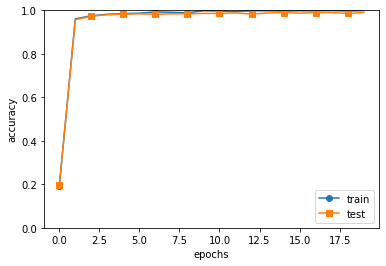

In [6]:
 # グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [4]:
x_train.shape

(60000, 1, 28, 28)

In [7]:
t_train.shape


(60000,)